In [1]:
import pip  
pip.main(['install', 'imutils']) 

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


Requirement already satisfied: imutils in c:\users\vimala k.v\appdata\local\programs\python\python311\lib\site-packages (0.5.3)

0

In [2]:
!pip install keras

In [3]:
!pip install tensorflow

In [4]:
!pip install scikit-learn

In [7]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [14]:
INIT_LR = 1e-4
EPOCHS = 10
BS = 32


In [15]:

DIRECTORY = r"D:\New folder\Face-Mask-Detection-master\dataset\"
CATEGORIES = ["with_mask", "without_mask"]


In [16]:
print("[INFO] loading images...")

[INFO] loading images...


In [17]:
data = []
labels = []

In [1]:
!pip install --upgrade tensorflow keras

     ------------------------------------ 999.1/999.1 kB 483.1 kB/s eta 0:00:00



[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:

DIRECTORY = r"D:\New folder\Face-Mask-Detection-master\dataset"
CATEGORIES = ["with_mask", "without_mask"]

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	data.append(image)
    	labels.append(category)

NameError: name 'os' is not defined

In [19]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [20]:
data = np.array(data, dtype="float32")
labels = np.array(labels)


In [21]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

In [22]:
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [23]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

WARNING: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


9406464/9406464 [==============================] - 12s 1us/step


In [24]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [25]:
model = Model(inputs=baseModel.input, outputs=headModel)

In [26]:
for layer in baseModel.layers:
	layer.trainable = False

In [27]:
from tensorflow.keras.optimizers import Adam

print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])


[INFO] compiling model...


WARNING: `lr` is deprecated in Keras optimizer, please use `learning_rate` or use the legacy optimizer, e.g.,tf.keras.optimizers.legacy.Adam.


In [28]:
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] training head...
Epoch 1/10
95/95 [==============================] - 291s 3s/step - loss: 0.1247 - accuracy: 0.9581 - val_loss: 0.0386 - val_accuracy: 0.9883
Epoch 2/10
95/95 [==============================] - 146s 2s/step - loss: 0.0531 - accuracy: 0.9842 - val_loss: 0.0362 - val_accuracy: 0.9896
Epoch 3/10
95/95 [==============================] - 151s 2s/step - loss: 0.0359 - accuracy: 0.9895 - val_loss: 0.0413 - val_accuracy: 0.9857
Epoch 4/10
95/95 [==============================] - 124s 1s/step - loss: 0.0299 - accuracy: 0.9898 - val_loss: 0.0285 - val_accuracy: 0.9896
Epoch 5/10
95/95 [==============================] - 124s 1s/step - loss: 0.0370 - accuracy: 0.9888 - val_loss: 0.0196 - val_accuracy: 0.9935
Epoch 6/10
95/95 [==============================] - 130s 1s/step - loss: 0.0373 - accuracy: 0.9878 - val_loss: 0.0270 - val_accuracy: 0.9896
Epoch 7/10
95/95 [==============================] - 119s 1s/step - loss: 0.0301 - accuracy: 0.9908 - val_loss: 0.0468 - val_accura

In [29]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)


[INFO] evaluating network...
24/24 [==============================] - 20s 752ms/step


In [30]:
  predIdxs = np.argmax(predIdxs, axis=1)

In [31]:
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       383
without_mask       0.99      0.99      0.99       384

    accuracy                           0.99       767
   macro avg       0.99      0.99      0.99       767
weighted avg       0.99      0.99      0.99       767



In [32]:
print("[INFO] saving mask detector model...")
model.save("mask_detector.model", save_format="h5")

[INFO] saving mask detector model...


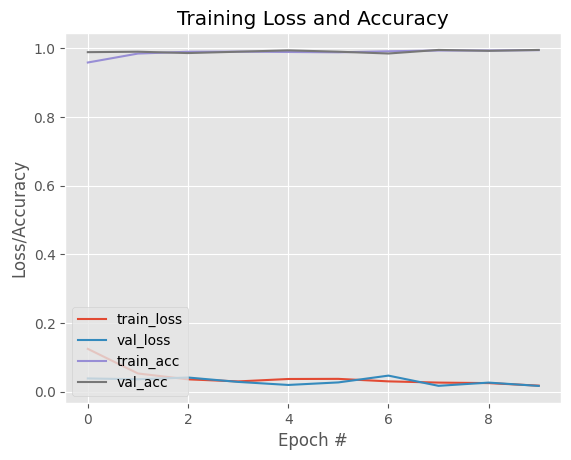

In [33]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")